<a href="https://colab.research.google.com/github/edongdongchen/EI/blob/main/ei_demo_cs_usps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import USPS
from torch.utils.data import DataLoader

import os
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# define an inverse problem e.g. Compressed Sensing (CS)
# where the forward operator A is a random projection matrix
class CS():
  def __init__(self, d, D, img_shape, dtype=torch.float, device='cuda:0'):
    self.img_shape = img_shape
    fname = './dataset/forw_cs_{}x{}.pt'.format(d, D)
    if os.path.exists(fname):
      A, A_dagger = torch.load(fname)
    else:
      A = np.random.randn(d, D) / np.sqrt(d)
      A_dagger = np.linalg.pinv(A)
      torch.save([A, A_dagger], fname)
      print('CS matrix has been created and saved at {}'.format(fname))
    self._A = torch.from_numpy(A).type(dtype).to(device)
    self._A_dagger = torch.from_numpy(A_dagger).type(dtype).to(device)

  def A(self, x):
    y = torch.einsum('in, mn->im', x.reshape(x.shape[0], -1), self._A)
    return y

  def A_dagger(self, y):
    N, C, H, W = y.shape[0], self.img_shape[0], self.img_shape[1], self.img_shape[2]
    x = torch.einsum('im, nm->in', y, self._A_dagger)
    x = x.reshape(N, C, H, W)
    return x

Plot the compressed measurement $y$ and its Groundtruth $x$. 

x (GT): torch.Size([1, 16, 16])	y: torch.Size([1, 64])


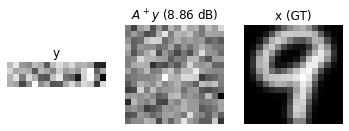

In [ ]:
dtype = torch.float
device = 'cuda:0'
batch_size = 1

# test set
test_dataset = USPS(root='./dataset/', train=False, download=True, transform=transforms.ToTensor())
test_dataloader=DataLoader(test_dataset,batch_size=1,shuffle=False)

# define a CS (4x) operator
physics = CS(64, 256, [1,16,16], dtype, device)
# ground-truh
x = test_dataset[0][0].type(dtype).to(device) #torch.Size([1, 1, 16, 16])
# measurement
y = physics.A(x)

print(f'x (GT): {x.shape}\ty: {y.shape}')

def torch2img(x):
  return x.squeeze().detach().cpu().numpy()
  
def cal_psnr(a, b):
  alpha = np.sqrt(a.shape[-1]*a.shape[-2])
  psnr = 20*torch.log10(alpha*torch.norm(b, float('inf'))/torch.norm(b-a, 2))
  return psnr.detach().cpu().numpy()

ATy = physics.A_dagger(y)
# have a look at the cs measurement y, A^+y, and the ground-truth x.
plt.subplot(1,3,1)
plt.imshow(torch2img(y.view(1,1,4,16)), cmap='gray'), plt.title('y'), plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(torch2img(ATy), cmap='gray'), plt.title(r'$A^+y$ ({:.2f} dB)'.format(cal_psnr(ATy, x))), plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(torch2img(x), cmap='gray'), plt.title('x (GT)'), plt.axis('off')
plt.show()



---
To learn an reconstruction function $f:y\rightarrow x$ by only using the measurements set $\{y\}$, 

We assume the signal set $\mathcal{X}$ is invariant to a groups of transformations $𝑇_𝑔$ related to a group 𝒢, where $T_gT_g^{\top}=I$. For example:
    
    - natural images are shift invariant.
    - in CT/MRI data, organs can be imaged at different angles making the problem invariant to rotation.

Key observations: 
- Invariance provides access to implicit operators $𝐴_𝑔=𝐴𝑇_𝑔$ with potentially different range spaces:  
<center>$𝐴𝑥=𝐴𝑇_𝑔T_g^{\top}x=𝐴_𝑔 \tilde{x}$,</center>
where $A_g=AT_g$ and $\tilde{x}=𝑇_𝑔^{\top}x$.

- The composition $𝑓∘𝐴$ is equivariant to the group of transformations ${𝑇_𝑔 }$:  $𝑓(𝐴𝑇_𝑔 𝑥)=𝑇_𝑔 𝑓(𝐴𝑥)$


# **ALL** you need is to:

1. define a transformation group $\{T_g\}$ based on the certain invariances to the signal set.
2. define a neural reconstruction function $f_\theta: y\rightarrow x$, *e.g.* $f_\theta=G_\theta\circ A^{\dagger}$ and $G_\theta$ could be an auto-encoder.

Then the Equivairant Imaging is very easy to do:

1. calculate $x^{(1)} = f_\theta(y)$ as the estimation of $x$.
2. calculate $x^{(2)} = T_g(x^{(1)})$ by transforming $x^{(1)}$.
2. calculate $x^{(3)} = f_\theta(Ax^{(2)})$ by reconstructing $x^{(2)}$ from its measurement $Ax^{(2)}$.


Finaly, **train** your **EI** model to learn the reconstruction function $f$ by solving: 

$\arg\min\limits_\theta\mathbb{E}_{y,g}\{\mathcal{L}(Ax^{(1)},y) +\lambda\mathcal{L}(x^{(2)},x^{(3)})\}$.







In [ ]:
# define a transformation group (random shift)
import random
class Shift():
  def __init__(self, n_trans):
    self.n_trans = n_trans
  def apply(self, x):
    H, W = x.shape[-2], x.shape[-1]
    assert self.n_trans <= H - 1 and self.n_trans <= W - 1, 'n_shifts should less than {}'.format(H-1)

    shifts_row = random.sample(list(np.concatenate([-1*np.arange(1, H), np.arange(1, H)])), self.n_trans)
    shifts_col = random.sample(list(np.concatenate([-1*np.arange(1, W), np.arange(1, W)])), self.n_trans)

    x = torch.cat([x if self.n_trans == 0 else torch.roll(x, shifts=[sx, sy], dims=[-2,-1]).type_as(x)
              for sx, sy in zip(shifts_row, shifts_col)], dim=0)
    return x

In [ ]:
# define residual unet
class UNet(nn.Module):
  def __init__(self, in_channels=1, out_channels=1, compact=4, residual=True, circular_padding=True, cat=True):
    super(UNet, self).__init__()
    self.name = 'unet'
    self.residual = residual
    self.cat = cat

    self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.Conv1 = conv_block(ch_in=in_channels, ch_out=64, circular_padding=circular_padding)
    self.Conv2 = conv_block(ch_in=64, ch_out=128)
    self.Conv3 = conv_block(ch_in=128, ch_out=256)
    self.Conv4 = conv_block(ch_in=256, ch_out=512)

    self.Up4 = up_conv(ch_in=512, ch_out=256)
    self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

    self.Up3 = up_conv(ch_in=256, ch_out=128)
    self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

    self.Up2 = up_conv(ch_in=128, ch_out=64)
    self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

    self.Conv_1x1 = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
  
  def forward(self, x):
    # encoding path
    cat_dim = 1
    input = x
    x1 = self.Conv1(input)

    x2 = self.Maxpool(x1)
    x2 = self.Conv2(x2)

    x3 = self.Maxpool(x2)
    x3 = self.Conv3(x3)

    d3 = self.Up3(x3)
    if self.cat:
        d3 = torch.cat((x2, d3), dim=cat_dim)
        d3 = self.Up_conv3(d3)

    d2 = self.Up2(d3)
    if self.cat:
        d2 = torch.cat((x1, d2), dim=cat_dim)
        d2 = self.Up_conv2(d2)

    d1 = self.Conv_1x1(d2)

    out = d1+x if self.residual else d1
    return out

class conv_block(nn.Module):
  def __init__(self, ch_in, ch_out, circular_padding=False):
    super(conv_block, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True,
                  padding_mode='circular' if circular_padding else 'zeros'),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(inplace=True),
        nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(inplace=True)
    )
  def forward(self, x):
    x = self.conv(x)
    return x

class up_conv(nn.Module):
  def __init__(self, ch_in, ch_out):
    super(up_conv, self).__init__()
    self.up = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    x = self.up(x)
    return x

Define the Neural Reconstruction Funtion $f_\theta=G_\theta\circ A^\dagger$:

In [ ]:
G = UNet().to(device)
f = lambda y: G(physics.A_dagger(y))

Define the transformation group $\{T_g\}$:


In [ ]:
T = Shift(n_trans=2) # random shift: return n_trans=2 randomly shifted versions of the input

**Start Training:**

In [ ]:
# Equivariant Imaging
lr = 5e-4 #5e-4
wd = 1e-8
batch_size=8
epochs = 500
ckp_interval = 100
# alpha = 10 # equivariance strength

dataloader=DataLoader(USPS(root='./dataset/',train=True,download=True, transform=transforms.ToTensor()),batch_size=batch_size,shuffle=True)
now = lambda: datetime.now().strftime('%y-%m-%d-%H:%M:%S')

def train(mode='ei', alpha=None):
  optimizer = torch.optim.Adam(G.parameters(), lr=lr, weight_decay=wd)
  mse = torch.nn.MSELoss().to(device)

  print(f'train {mode}...')
  save_path = './ckp/{}_cs4x_{}{}'.format(now(), mode, '' if alpha is None else alpha)
  os.makedirs(save_path, exist_ok=True)

  for epoch in range(epochs):
    loss_mc_epoch, loss_ei_epoch, loss_epoch, psnr_epoch = [], [], [], []
    for i, x in enumerate(dataloader):
      x = x[0].type(dtype).to(device) #torch.Size([4, 1, 16, 16])
      y = physics.A(x) #generate the measurements for training
      x1 = f(y) #reconstruction

      if mode=='sup':
        loss = mse(x1, x)
      if mode=='mc':
        loss = mse(physics.A(x1), y)
      if mode=='ei': #(only 2 lines code to learn x w/o GT)
        x2 = T.apply(x1)
        x3 = f(physics.A(x2))
        loss = mse(physics.A(x1), y) + alpha * mse(x3, x2)

      loss_epoch.append(loss.item())
      psnr_epoch.append(cal_psnr(x1, x))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print('{}\t[{}/{}]\tloss={:.4e}\tpsnr={:.3f}'.format(now(), epoch,epochs,np.mean(loss_epoch), np.mean(psnr_epoch)))
    
    # save the trained model
    if epoch % ckp_interval == 0 or epoch + 1 == epochs:
      state = {'epoch': epoch, 'state_dict': G.state_dict(), 'optimizer': optimizer.state_dict()} 
      torch.save(state, os.path.join(save_path, 'ckp_{}.pth.tar'.format(epoch)))

train('ei',10)
train('ei',1)
train('sup')
train('mc')


train ei...
21-09-17-15:15:25	[0/500]	loss=1.1504e-01	psnr=5.180
21-09-17-15:16:08	[1/500]	loss=4.8247e-02	psnr=7.979
21-09-17-15:16:51	[2/500]	loss=3.6663e-02	psnr=9.037
21-09-17-15:17:34	[3/500]	loss=3.1511e-02	psnr=9.629
21-09-17-15:18:17	[4/500]	loss=2.8984e-02	psnr=9.974
21-09-17-15:19:00	[5/500]	loss=2.7200e-02	psnr=10.338
21-09-17-15:19:43	[6/500]	loss=2.5441e-02	psnr=10.677
21-09-17-15:20:26	[7/500]	loss=2.3814e-02	psnr=10.939
21-09-17-15:21:09	[8/500]	loss=2.2801e-02	psnr=11.118
21-09-17-15:21:52	[9/500]	loss=2.1785e-02	psnr=11.322
21-09-17-15:22:36	[10/500]	loss=2.0702e-02	psnr=11.448
21-09-17-15:23:19	[11/500]	loss=1.9855e-02	psnr=11.614
21-09-17-15:24:02	[12/500]	loss=1.9236e-02	psnr=11.676
21-09-17-15:24:45	[13/500]	loss=1.8321e-02	psnr=11.792
21-09-17-15:25:28	[14/500]	loss=1.7264e-02	psnr=11.934
21-09-17-15:26:11	[15/500]	loss=1.6937e-02	psnr=11.983
21-09-17-15:26:54	[16/500]	loss=1.6336e-02	psnr=12.025
21-09-17-15:27:37	[17/500]	loss=1.5818e-02	psnr=12.149
21-09-17-15:2

**Test** a trained EI model.

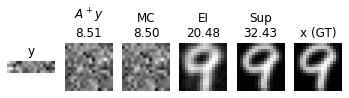

In [ ]:
# Test
ckp_sup = './ckp/21-09-17-12:39:23_cs4x_sup/ckp_29.pth.tar'
ckp_mc = './ckp/21-09-17-12:48:50_cs4x_mc/ckp_29.pth.tar'
ckp_ei = './ckp/21-09-17-12:58:21_cs4x_ei/ckp_29.pth.tar'

unet = UNet().to(device)
def test(net, ckp, ATy):
  checkpoint = torch.load(ckp, map_location=device)
  net.load_state_dict(checkpoint['state_dict'])
  net.to(device).eval()
  return net(ATy)

# ground-truh
x = test_dataset[0][0].type(dtype).to(device) #torch.Size([1, 1, 16, 16])
# measurement
y = physics.A(x)
ATy = physics.A_dagger(y)

x_ei = test(unet, ckp_ei, ATy)
x_mc = test(unet, ckp_mc, ATy)
x_sup = test(unet, ckp_sup, ATy)

plt.subplot(1,6,1)
plt.imshow(torch2img(y.view(1,1,4,16)), cmap='gray'), plt.title('y'), plt.axis('off')
plt.subplot(1,6,2)
plt.imshow(torch2img(ATy), cmap='gray'), plt.title(r'$A^+y$'+'\n{:.2f}'.format(cal_psnr(ATy, x))), plt.axis('off')
plt.subplot(1,6,3)
plt.imshow(torch2img(x_mc), cmap='gray'), plt.title('MC\n{:.2f}'.format(cal_psnr(x_mc, x))), plt.axis('off')
plt.subplot(1,6,4)
plt.imshow(torch2img(x_ei), cmap='gray'), plt.title('EI\n{:.2f}'.format(cal_psnr(x_ei, x))), plt.axis('off')
plt.subplot(1,6,5)
plt.imshow(torch2img(x_sup), cmap='gray'), plt.title('Sup\n{:.2f}'.format(cal_psnr(x_sup, x))), plt.axis('off')
plt.subplot(1,6,6)
plt.imshow(torch2img(x), cmap='gray'), plt.title('x (GT)'), plt.axis('off')
plt.show()